In [ ]:
# GAN(Generative Adversarial Network)
# 적대적 생성 모델
# 생성 모델 : 데이터의 형태를 만들어 내는 모델, 어떤 분포 혹은 분산 자체를 만들어내는 모델
# 적대적 : 지폐위조범(Generator)과 경찰(Discriminator)
# Generator: 새로운 데이터의 형태를 만들어 내는 모델, 판독 모델을 틀리도록 하는 역할(적대적 모델), 진짜 같은 가짜를 생성해내는 모델
# Discriminator: 데이터 판독 모델(Real, Fake 판독)

In [1]:
import torch
import random
# real 이미지 생성 함수
def generate_real():
    #random.uniform(a,b) a~b 랜덤실수
    real_data = torch.FloatTensor(
        [random.uniform(0.8, 1.0),
        random.uniform(0.0, 0.2),
        random.uniform(0.8, 1.0),
        random.uniform(0.0, 0.2)])
    return real_data

In [2]:
# random 이미지 생성 함수
def generate_random(size):
    # 평균 0, 표준편차 1인 정규분포 난수 생성
    random_data = torch.rand(size)
    return random_data

In [3]:
import torch.nn as nn
import pandas as pd
# 판별모형
class Discriminator(nn.Module):

    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(4, 3),
            nn.Sigmoid(),
            nn.Linear(3, 1),
            nn.Sigmoid()
        )

        self.loss_function = nn.MSELoss()
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)
        self.counter = 0
        self.progress = []

    def forward(self, inputs):
            return self.model(inputs)

    def train(self, inputs, targets):
        outputs = self.forward(inputs)

        loss = self.loss_function(outputs, targets)
        self.counter += 1
        if self.counter % 10 == 0:
            self.progress.append(loss.item())

        if self.counter % 10000 == 0:
            print("counter = ", self.counter)
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

In [4]:
D = Discriminator()
for i in range(10000):
    # real image
    D.train(generate_real(), torch.FloatTensor([1.0]))
    # fake image
    D.train(generate_random(4), torch.FloatTensor([0.0]))

counter =  10000
counter =  20000


In [5]:
print( D.forward( generate_real() ).item() )
print( D.forward( generate_random(4) ).item() )

0.7161149978637695
0.13189402222633362


In [6]:
# 생성모형
class Generator(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(1, 3),
            nn.Sigmoid(),
            nn.Linear(3, 4),
            nn.Sigmoid()
        )

        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)
        self.counter = 0
        self.progress = []

    def forward(self, inputs):
        return self.model(inputs)
    
    def train(self, D, inputs, targets):
        g_output = self.forward(inputs)
        d_output = D.forward(g_output)
        
        loss = D.loss_function(d_output, targets)
        self.counter += 1
        if self.counter % 10 == 0:
            self.progress.append(loss.item())
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

In [7]:
G = Generator()
G.forward(torch.FloatTensor([0.5]))

tensor([0.5481, 0.3726, 0.3595, 0.4437], grad_fn=<SigmoidBackward0>)

In [8]:
D = Discriminator()
G = Generator()
image_list = []
for i in range(10000):
    # 판별모형 학습(true)
    D.train(generate_real(), torch.FloatTensor([1.0]))

    # 판별모형 학습(false)
    D.train(G.forward(torch.FloatTensor([0.5])).detach(), torch.FloatTensor([0.0]))

    # 생성모형 학습
    G.train(D, torch.FloatTensor([0.5]), torch.FloatTensor([1.0]))

    if i % 1000 == 0:
        image_list.append( G.forward(torch.FloatTensor([0.5])).detach().numpy() )

counter =  10000
counter =  20000


In [9]:
G.forward(torch.FloatTensor([0.5]))

tensor([0.9311, 0.0354, 0.9448, 0.0378], grad_fn=<SigmoidBackward0>)

In [10]:
# 생성된 패턴
image_list

[array([0.55095434, 0.6156379 , 0.3912656 , 0.69365114], dtype=float32),
 array([0.5783277 , 0.6082731 , 0.398298  , 0.69878536], dtype=float32),
 array([0.6143602 , 0.57588106, 0.42414442, 0.6955482 ], dtype=float32),
 array([0.6679062 , 0.48553282, 0.48822093, 0.66127586], dtype=float32),
 array([0.7356009, 0.3153096, 0.6117275, 0.5326111], dtype=float32),
 array([0.8009114 , 0.1661402 , 0.754468  , 0.28763548], dtype=float32),
 array([0.84959346, 0.09565625, 0.8461058 , 0.13807812], dtype=float32),
 array([0.8825656 , 0.06474405, 0.8937814 , 0.08186258], dtype=float32),
 array([0.9047622 , 0.04934385, 0.91967696, 0.05761629], dtype=float32),
 array([0.9201619 , 0.04069065, 0.9350412 , 0.04507779], dtype=float32)]

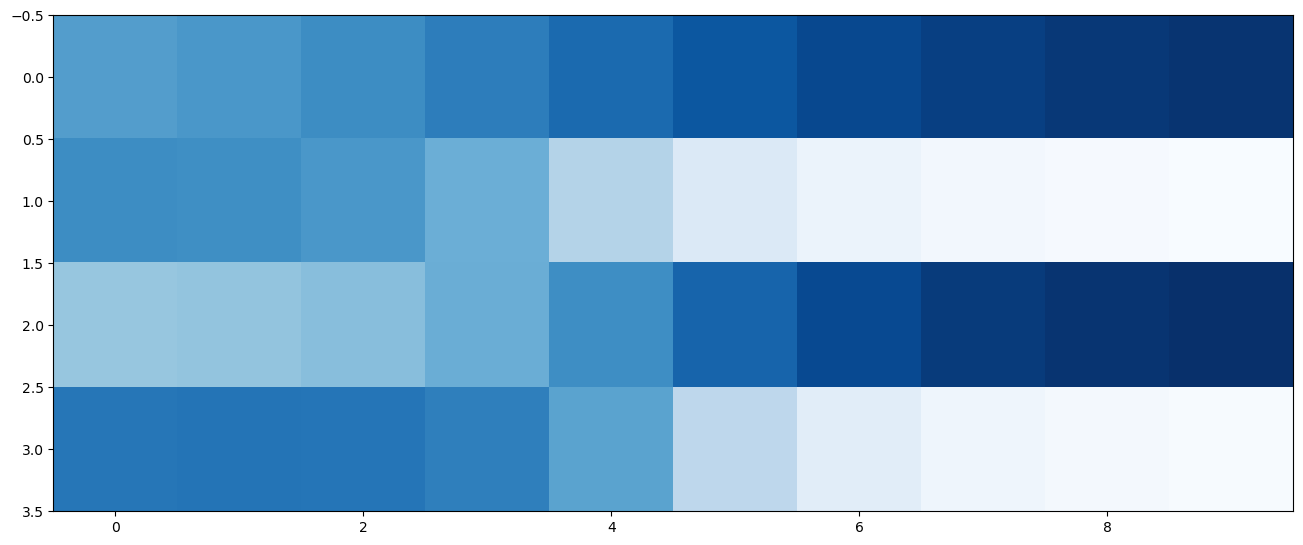

In [11]:
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np
plt.figure(figsize = (16,8))
plt.imshow(np.array(image_list).T, interpolation='none', cmap='Blues')
plt.show()